In [ ]:
import os
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from bs4 import BeautifulSoup
import geopandas as gpd
import re
import math
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import scipy.stats

## **Part 1**

In [ ]:
TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
WEATHER_URL = "https://www.ncei.noaa.gov/access/search/data-search/local-climatological-data?stations=72505394728"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"

CRS = 4326

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [ ]:
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        pass
    else:
        raise

For the link_matches function, we wanted the taxi data from January 2020 through August 2024. We are using the data for yellow taxi trips and for high-volume for hire vehicle trips. We made the link_matches function with the input of a string for the URL site, and the output to be True or False to indicate that the URL matches the regex pattern we want. Using the downloaded data, we wanted anything that said yellow or fhvhv. We then used match to check if the string from the links matched our pattern, and if not, then it would return False. Then by taking the month and year, we got the capture groups, which allows us to look at the specific parts of the regex. In the regex, the group(1) and group(2) will check the year and month of the data we want. So to ensure if the dates are what we want, the function will return True or False.



In [ ]:
"""Finds the correct data we want to look at from the TLC_URL data.
  Takes in a string input from URL link and returns True or False to ensure the format matches the regex pattern we want.
  If link matches regex re.match() returns the object and gets month and year to check if its within the dates we want.
"""
def link_matches(link:str)-> bool:
    regex = r"^https:..d37ci6vzurychx.cloudfront.net/trip-data/(?:fhvhv|yellow)_tripdata_(\d{4})-(\d{2}).parquet"
    match = re.match(regex,link)
    if match is None:
        return False
    year = int(match.group(1))
    month = int(match.group(2))
    if year < 2020:
        return False
    if year > 2024:
        return False
    if year == 2024 and month > 8:
        return False
    return True


In [ ]:
"""
Downloads files from URLs (str) based off the category and filters it.
Makes an HTTP get request to get the files and save them to the directory.
"""
def download_file(urls: str, category):
    filtered_urls = [url for url in urls if category in url]
    if category == "yellow":
      for url in filtered_urls:
          try:
              response = requests.get(url)
              response.raise_for_status()  # Raise error if the request fails
              print(f"Requested: {url}")

              name = os.path.basename(url)
              file_name = os.path.splitext(name)[0]
              path = os.path.join(dir_yellow, file_name)

              with open(path, "wb") as file:
                file.write(response.content)
                print(f"Saved: {file_name}")
          except requests.RequestException as e:
              print(f"File Failed to download {url}. Error: {e}")
    else:
      for url in filtered_urls:
          try:
              response = requests.get(url)
              response.raise_for_status()  # Raise error if the request fails
              print(f"Requested: {url}")

              name = os.path.basename(url)
              file_name = os.path.splitext(name)[0]
              path = os.path.join(dir_uber, file_name)

              with open(path, "wb") as file:
                file.write(response.content)
                print(f"Saved: {file_name}")
          except requests.RequestException as e:
              print(f"Failed to download {url}. Error: {e}")

In [ ]:
"""
Gets and filters URLs from TLC website.
Sends an HTTP request to get data from TLC_URL and parses the
HTML to extract links, and filters the links based on the link_matches() function.
Will return a list of filtered URLs for taxi trip.
"""
def load_taxi_zones(shapefile):
    response = requests.get(TLC_URL)
    parser = bs4.BeautifulSoup(response.content, "html.parser")
    links = [l.get('href') for l in parser.find_all('a')]
    filtered_links = [link for link in links if link_matches(link)]
    return filtered_links

In [ ]:
dir_yellow = "Yellow Dataset"
dir_uber = "Uber Dataset"
os.makedirs(dir_yellow, exist_ok=True)
os.makedirs(dir_uber, exist_ok=True)
links = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
links = [link.strip() for link in links]
download_file(links, "yellow")
download_file(links, "fhvhv")

Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet
Saved: yellow_tripdata_2024-01
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet
Saved: yellow_tripdata_2024-02
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet
Saved: yellow_tripdata_2024-03
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet
Saved: yellow_tripdata_2024-04
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet
Saved: yellow_tripdata_2024-05
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet
Saved: yellow_tripdata_2024-06
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet
Saved: yellow_tripdata_2024-07
Requested: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-08.parquet
Saved: yellow_tripdata_2024-08
Requested: https://d37ci

In [ ]:
"""
The def get_population(path) function opens the parquet file from the path and returns the number of rows,
which is the population size of the data.
"""
def get_population(path):
    data = pq.ParquetFile(path)
    return data.metadata.num_rows

"""
The calculate_sample_size(population) applies the Cochran formula to get the required sample size for the population.
Returns the sample size, which is the number of data given the population, confidence interval, and error.
"""
def calculate_sample_size(population):
    Z = 1.96  # Z-score for 95% confidence level
    p = 0.5   # Maximum variability
    e = 0.05  # Margin of error (5%)

    # Cochran's formula for an infinite population
    n0 = (Z**2 * p * (1 - p)) / (e**2)

    # Adjust for finite population
    sample_size = n0 / (1 + (n0 - 1) / population)

    return sample_size

In [ ]:
yellow_population = []
uber_population = []

for file_name in os.listdir("Yellow Dataset"):
    file_path = os.path.join("Yellow Dataset", file_name)
    yellow_population.append(get_population(file_path))

for file_name in os.listdir("Uber Dataset"):
    file_path = os.path.join("Uber Dataset", file_name)
    uber_population.append(get_population(file_path))


yellow_size = math.floor(calculate_sample_size(sum(yellow_population)/len(yellow_population)))
uber_size = math.floor(calculate_sample_size(sum(uber_population)/len(uber_population)))
print(f"Yellow sample size: {yellow_size}")
print(f"Uber sample size: {uber_size}")

Yellow sample size: 384
Uber sample size: 384


In [ ]:
taxi_zones = gpd.read_file("/content/taxi_zones.shp")
if taxi_zones.crs != "EPSG:4326":
    taxi_zones = taxi_zones.to_crs(epsg=4326)

taxi_zones["centroid"] = taxi_zones.geometry.centroid

taxi_zones["longitude"] = taxi_zones["centroid"].x
taxi_zones["latitude"] = taxi_zones["centroid"].y

taxi_zones = taxi_zones.drop(columns=["centroid"])

<ipython-input-68-ad3b4d3c91e0>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones["centroid"] = taxi_zones.geometry.centroid


In [ ]:
min_lat, max_lat, min_long, max_long = 40.560445, 40.908524, -74.242330, -73.717047

"""
Functions cleans taxi trip data from Parquet files.
Merges location data based off of pickup and dropoff IDs and filters out invalid data.
Renames columns and returns data frames with lat and long.
"""
def yellow_sample_clean_data(path):
    df = pd.read_parquet(path)
    df = df.sample(n=yellow_size)

    # location ID
    df = df.merge(taxi_zones, how="left", left_on="PULocationID", right_on="LocationID")
    df = df.rename(columns={"longitude": "long_pickup", "latitude": "lat_pickup"})

    df = df.merge(taxi_zones, how="left", left_on="DOLocationID", right_on="LocationID")
    df = df.rename(columns={"longitude": "long_dropoff", "latitude": "lat_dropoff"})

    # remove invalid datapoints
    df = df[df["fare_amount"] != 0]
    df = df[df["trip_distance"] != 0]
    df = df[df["tpep_pickup_datetime"] != df["tpep_dropoff_datetime"]]

    # normalize column names
    df.rename(
    columns={
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "tip_amount" : "tips",
        "mta_tax" : "taxes",
        "tolls_amount" : "tolls"
        },inplace=True)

    # ensure all relevant columns exist, and fill missing ones with 0
    columns_to_check = ["extra", "improvement_surcharge", "congestion_surcharge", "airport_fee"]
    for column in columns_to_check:
        if column not in df.columns:
            df[column] = 0  # add missing column with 0 as the default value
        else:
            df[column] = df[column].fillna(0)  # fill NaN with 0 in existing columns

    # create new columns
    df["surcharges"] = (df["extra"] + df["improvement_surcharge"] + df["congestion_surcharge"] + df["airport_fee"])
    df["date"] = pd.to_datetime(df["pickup_datetime"]).dt.date

    # remove unnecessary columns
    df = df[['pickup_datetime', 'dropoff_datetime','date','taxes','surcharges',
       'trip_distance','fare_amount', 'tips', 'tolls','total_amount','lat_pickup',
             'lat_dropoff','long_pickup','long_dropoff']]

    # longitude/latitude box filter
    df = df[
    (df["lat_pickup"].between(min_lat, max_lat)) &
    (df["long_pickup"].between(min_long, max_long)) &
    (df["lat_dropoff"].between(min_lat, max_lat)) &
    (df["long_dropoff"].between(min_long, max_long))]

    return(df)

"""
Functions cleans uber trip data from Parquet files.
Merges location data based off of pickup and dropoff IDs and filters out invalid data.
If not an Uber ride, it'll be removed
Renames columns and returns data frames with lat and long.
"""
def uber_sample_clean_data(path):
    df = pd.read_parquet(path)

    df = df.sample(n=uber_size)

    # remove non uber rides
    df = df[df['hvfhs_license_num'] == 'HV0003']

    # location ID
    df = df.merge(taxi_zones, how="left", left_on="PULocationID", right_on="LocationID")
    df = df.rename(columns={"longitude": "long_pickup", "latitude": "lat_pickup"})

    df = df.merge(taxi_zones, how="left", left_on="DOLocationID", right_on="LocationID")
    df = df.rename(columns={"longitude": "long_dropoff", "latitude": "lat_dropoff"})

    # remove invalid datapoints
    df = df[df["trip_miles"] != 0]
    df = df[df["trip_time"] != 0]

    # create date, total amount
    df["date"] = pd.to_datetime(df["pickup_datetime"]).dt.date
    df["total_amount"] = df["base_passenger_fare"] + df["bcf"] + df["tolls"] + df["sales_tax"]
    + df["congestion_surcharge"] + df["airport_fee"]
    df["surcharges"]= df["bcf"] + df["congestion_surcharge"] + df["airport_fee"]

    # rename columns
    df.rename(
    columns={
        "sales_tax": "taxes",
        "base_passenger_fare": "fare_amount",
        "tip_amount" : "tips",
        "tolls_amount" : "tolls"
        },inplace=True)

    # remove unnecessary columns
    df = df[['pickup_datetime',
       'dropoff_datetime','trip_miles','total_amount','surcharges','taxes','fare_amount','tolls','date', 'tips','lat_pickup',
             'lat_dropoff','long_pickup','long_dropoff']]

    # longitude/latitude box filter
    df = df[
    (df["lat_pickup"].between(min_lat, max_lat)) &
    (df["long_pickup"].between(min_long, max_long)) &
    (df["lat_dropoff"].between(min_lat, max_lat)) &
    (df["long_dropoff"].between(min_long, max_long))]

    return(df)


Gets the path to the directory where the taxi/Uber data is and assigns it to the variable. The code then initializes it into an empty DataFrame. The for loop will then go through each file in the data directory and creates the full file path. The monthly_sample line processes the file_path and calls the previous sample_clean_data function. It will then append the cleaned data for the month to the yellow_samples/uber_samples DataFrame.

In [ ]:
#Sample All Yellow
yellow_data_dir = "/content/Yellow Dataset"

# Initialize an empty DataFrame to hold the aggregated sample
yellow_samples = pd.DataFrame()

# Iterate over all files in the "Yellow Dataset" folder
for file_name in os.listdir(yellow_data_dir):

    file_path = os.path.join(yellow_data_dir, file_name)

    # Run the sampling and cleaning function
    monthly_sample = yellow_sample_clean_data(file_path)

    # Append the monthly sample to the aggregated sample
    yellow_samples = pd.concat([yellow_samples, monthly_sample], ignore_index=True)


<ipython-input-12-c1d935d529c9>:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].fillna(0)  # Fill NaN with 0 in existing columns
<ipython-input-12-c1d935d529c9>:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].fillna(0)  # Fill NaN with 0 in existing columns
<ipython-input-12-c1d935d529c9>:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.

In [ ]:
#Sample All Uber
uber_data_dir = "/content/Uber Dataset"

# Initialize an empty DataFrame to hold the aggregated sample
uber_samples = pd.DataFrame()

# Iterate over all files in the "Yellow Dataset" folder
for file_name in os.listdir(uber_data_dir):

    file_path = os.path.join(uber_data_dir, file_name)

    # Run the sampling and cleaning function
    monthly_sample = uber_sample_clean_data(file_path)

    # Append the monthly sample to the aggregated sample
    uber_samples = pd.concat([uber_samples, monthly_sample], ignore_index=True)

<ipython-input-15-3c7a7f4862ac>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  uber_samples = pd.concat([uber_samples, monthly_sample], ignore_index=True)
<ipython-input-15-3c7a7f4862ac>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  uber_samples = pd.concat([uber_samples, monthly_sample], ignore_index=True)


In [ ]:
# Weather Data Preparation

The get_clean_weather function will read a CSV file uploaded by us into our program from the NOAA site/the CSV files given to us. Hourly_df line will keep the relevant information from the CSV files and ignore any other column. The columns are then converted into strings for cleanup. This will remove any non-numeric characters from the data. Once the values are cleaned as strings, the columns are converted to floats. The DATE column is converted to a datetime object. The date and time are extracted into their own columns, and the original DATE column is dropped. The hourly_df is then copied to make a daily_df, which is then grouped by the date column to get the Average windspeed (avg_windspeed), Total precipitation (total_precipitation), Total snowfall (total_snowfall).

In [ ]:
"""
Processes and cleans weather data from hourly CSV files and converts them into daily data.
Returns a tuple containg two DataFrames (daily_df, hourly_df)
Obtains data such as wind speed, snowfall, precupitation
"""
def get_clean_weather(file):
    # Read the CSV file
    hourly_df = pd.read_csv(file)

    # Keep only the relevant columns
    hourly_df = hourly_df[['DATE', 'HourlyPrecipitation','HourlyWindSpeed','DailySnowfall']]

    # Convert columns to strings for cleanup
    hourly_df['HourlyPrecipitation'] = hourly_df['HourlyPrecipitation'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    hourly_df['HourlyWindSpeed'] = hourly_df['HourlyWindSpeed'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
    hourly_df['DailySnowfall'] = hourly_df['DailySnowfall'].astype(str).str.replace(r'[^0-9.]', '', regex=True)

    # Convert cleaned strings to numeric values
    hourly_df['HourlyPrecipitation'] = pd.to_numeric(hourly_df['HourlyPrecipitation'], errors='coerce')
    hourly_df['HourlyWindSpeed'] = pd.to_numeric(hourly_df['HourlyWindSpeed'], errors='coerce')
    hourly_df['DailySnowfall'] = pd.to_numeric(hourly_df['DailySnowfall'], errors='coerce')

    # Extract date and time
    hourly_df['DATE'] = pd.to_datetime(hourly_df['DATE'])
    hourly_df['date'] = hourly_df['DATE'].dt.date  # Separate date (no time)
    hourly_df['time'] = hourly_df['DATE'].dt.time  # Separate time
    hourly_df = hourly_df.drop(columns=['DATE'])

    # Prepare the daily DataFrame
    daily_df = hourly_df.copy()
    daily_df['date'] = pd.to_datetime(daily_df['date'])  # Ensure it's datetime type for groupby
    daily_df = daily_df.groupby('date').agg(
        avg_windspeed=('HourlyWindSpeed', 'mean'),
        total_precipitation=('HourlyPrecipitation', 'sum'),
        total_snowfall=('DailySnowfall','sum')
    ).reset_index()

    hourly_df.rename(columns={
    'HourlyPrecipitation': 'precipitation',
    'HourlyWindSpeed': 'windspeed','DailySnowfall': 'snowfall'}, inplace=True)

    return daily_df, hourly_df

Once the CSV files were uploaded to our program, they were called and pd.concat is used to concatenate the DataFrames along the rows.  The ignore_index=True ensures that the index is reset, providing a continuous index across all rows from different years. The result is stored in the daily_weather DataFrame, which now contains all the daily weather data from 2020 to 2024.


In [ ]:
weather_2020 = get_clean_weather("/content/2020_weather.csv")
weather_2021 = get_clean_weather("/content/2021_weather.csv")
weather_2022 = get_clean_weather("/content/2022_weather.csv")
weather_2023 = get_clean_weather("/content/2023_weather.csv")
weather_2024 = get_clean_weather("/content/2024_weather.csv")

daily_weather = pd.concat([weather_2020[0],weather_2021[0],weather_2022[0],weather_2023[0],weather_2024[0]],
                          axis=0, ignore_index=True)
hourly_weather = pd.concat([weather_2020[1],weather_2021[1],weather_2022[1],weather_2023[1],weather_2024[1]],
                          axis=0, ignore_index=True)

<ipython-input-70-37f0dbf3689b>:8: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(file)
<ipython-input-70-37f0dbf3689b>:8: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(file)
<ipython-input-70-37f0dbf3689b>:8: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(file)
<ipython-input-70-37f0dbf3689b>:8: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(file)
<ipython-input-70-37f0dbf3689b>:8: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(file)


## **Part 2**

In [ ]:
from sqlalchemy import create_engine, Column, Integer, Float, String, Text
from sqlalchemy.orm import declarative_base

Each class represents their own table.  Each attribute like pickup_datetime, fare_amount, tip_amount, avg_windspeed, etc. corresponds to a column in table. Each table is different based off the data/what is needed. Similarly, a schema is made in SQL to help organize the data and form relationships later on in the project.

In [ ]:
engine = create_engine(DATABASE_URL)

# Define the base class
Base = declarative_base()

class YellowTrips(Base):
    __tablename__ = 'yellow_trips'
    id = Column(Integer, primary_key=True, autoincrement=True)
    pickup_datetime = Column(String)
    dropoff_datetime = Column(String)
    date = Column(String)
    trip_distance = Column(Float)
    long_pickup = Column(Float)
    lat_pickup = Column(Float)
    long_dropoff = Column(Float)
    lat_dropoff = Column(Float)
    tips = Column(Float)
    total_amount = Column(Float)
    surcharges = Column(Float)
    fare_amount = Column(Float)
    tolls = Column(Float)
    taxes = Column(Float)

# Define the Uber Trips table
class UberTrips(Base):
    __tablename__ = "uber_trips"
    id = Column(Integer, primary_key=True, autoincrement=True)
    pickup_datetime = Column(Text)
    dropoff_datetime = Column(Text)
    date = Column(Text)
    trip_miles = Column(Float)
    long_pickup = Column(Float)
    lat_pickup = Column(Float)
    long_dropoff = Column(Float)
    lat_dropoff = Column(Float)
    total_amount = Column(Float)
    tips = Column(Float)
    surcharges = Column(Float)
    fare_amount = Column(Float)
    tolls = Column(Float)
    taxes = Column(Float)


# Define the Hourly Weather table
class HourlyWeather(Base):
    __tablename__ = "hourly_weather"
    id = Column(Integer, primary_key=True, autoincrement=True)
    date = Column(Text)
    time = Column(Text)
    precipitation = Column(Float)
    windspeed = Column(Float)
    snowfall = Column(Float)

# Define the Daily Weather table
class DailyWeather(Base):
    __tablename__ = "daily_weather"
    id = Column(Integer, primary_key=True, autoincrement=True)
    date = Column(Text)
    total_precipitation = Column(Float)
    avg_windspeed = Column(Float)
    total_snowfall = Column(Float)

#create tables
Base.metadata.create_all(engine)


In [ ]:
#create schema
# SQL schema text
schema = """
CREATE TABLE IF NOT EXISTS yellow_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    date TEXT,
    trip_distance FLOAT,
    long_pickup FLOAT,
    lat_pickup FLOAT,
    long_dropoff FLOAT,
    lat_dropoff FLOAT,
    tips FLOAT,
    total_amount FLOAT,
    surcharges FLOAT,
    fare_amount FLOAT,
    tolls FLOAT,
    taxes FLOAT
);

CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    date TEXT,
    trip_miles FLOAT,
    long_pickup FLOAT,
    lat_pickup FLOAT,
    long_dropoff FLOAT,
    lat_dropoff FLOAT,
    total_amount FLOAT,
    tips FLOAT,
    surcharges FLOAT,
    fare_amount FLOAT,
    tolls FLOAT,
    taxes FLOAT
);


CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    time TEXT,
    precipitation FLOAT,
    windspeed FLOAT,
    snowfall FLOAT
);

CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    total_precipitation FLOAT,
    avg_windspeed FLOAT,
    total_snowfall FLOAT
;
"""

# Write schema to a file named "schema.sql"
with open("schema.sql", "w") as file:
    file.write(schema)

print("Schema file 'schema.sql' created successfully.")


Schema file 'schema.sql' created successfully.


Each line essentially takes its DataFrame and inserts it into its corresponding table in the database. The con=engine, specifies the database connection.

In [ ]:
# Insert `daily_weather` into the `daily_weather` table
daily_weather.to_sql('daily_weather', con=engine, if_exists='append', index=False)

# Insert `hourly_weather` into the `hourly_weather` table
hourly_weather.to_sql('hourly_weather', con=engine, if_exists='append', index=False)

# Insert `yellow_samples` into the `yellow_trips` table
yellow_samples.to_sql('yellow_trips', con=engine, if_exists='append', index=False)

# Insert `uber_samples` into the `uber_trips` table
uber_samples.to_sql('uber_trips', con=engine, if_exists='append', index=False)

14954

## **Part 3**

In [ ]:
import sqlite3
db_path = '/content/project.db'
conn = sqlite3.connect(db_path)

**Query 1:** What’s the most popular hour to take a taxi?

In [ ]:
QUERY_1 = """
SELECT
    strftime('%H', pickup_datetime) AS hour,
    COUNT(*) AS ride_cnt
FROM
    yellow_trips
GROUP BY
    hour
ORDER BY
    ride_cnt DESC;
"""

with conn:
    result = conn.execute(QUERY_1).fetchall()

print(result)
max = result[0]
print(f"The most popular hour is {max[0]} with {max[1]} rides.")

# Save the query to the file
file_name = "popular_hour.sql"

with open(file_name, "w") as file:
    file.write(QUERY_1)

[('18', 1440), ('17', 1414), ('15', 1394), ('14', 1337), ('16', 1293), ('19', 1246), ('13', 1233), ('12', 1207), ('11', 1176), ('20', 1106), ('10', 1018), ('21', 1016), ('09', 937), ('22', 891), ('08', 885), ('23', 742), ('07', 656), ('00', 502), ('06', 356), ('01', 351), ('02', 199), ('03', 156), ('05', 140), ('04', 105)]
The most popular hour is 18 with 1440 rides.


**Query 2:** What’s the most popular day of the week to take an Uber?

In [ ]:
QUERY_2 = """
SELECT
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM
    uber_trips
GROUP BY
    day_of_week
ORDER BY
    ride_count DESC;
"""

with conn:
    result = conn.execute(QUERY_2).fetchall()

days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

print("Popularity of Uber rides for each day of the week:")

maxday = -1
maxrides = -1

for row in result:
    day_name = days[int(row[0])]  # Convert day_of_week to name
    print(f"{day_name}: {row[1]} rides")
    if maxday == -1 or int(row[1]) > maxrides:
      maxday = int(row[0])
      maxrides = int(row[1])
print(f"Popular day: {days[maxday]} with {maxrides} rides")

# Save the query to the file
file_name = "popular_day.sql"

with open(file_name, "w") as file:
    file.write(QUERY_2)

Popularity of Uber rides for each day of the week:
Saturday: 2480 rides
Friday: 2343 rides
Thursday: 2135 rides
Sunday: 2114 rides
Wednesday: 2058 rides
Monday: 1920 rides
Tuesday: 1904 rides
Popular day: Saturday with 2480 rides


**Query 3:** What’s the 95% percentile of trip distance in January 2024?

In [ ]:
QUERY_3 = """
WITH combined_trips AS (
    SELECT trip_distance AS distance
    FROM yellow_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'

    UNION ALL

    SELECT trip_miles AS distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
sorted_trips AS (
    SELECT distance,
           ROW_NUMBER() OVER (ORDER BY distance) AS row_num,
           COUNT(*) OVER () AS total_rows
    FROM combined_trips
)
SELECT distance AS p95_distance
FROM sorted_trips
WHERE row_num = CAST(0.95 * total_rows AS INT);
"""

# Execute the query
with conn:
    result = conn.execute(QUERY_3).fetchone()

if result:
    p95_distance = result[0]  # Extract the 95th percentile
    print(f"95th Percentile of trip distance in January 2024: {p95_distance}")
else:
    print("No data found for the query.")

# Save the query to a file
file_name = "95_percentile_distance.sql"

with open(file_name, "w") as file:
    file.write(QUERY_3)

95th Percentile of trip distance in January 2024: 12.12


**Query 4:** What was the weather like for the busiest days in 2023?

In [ ]:
QUERY_4 = """
    SELECT
        rides.date,
        COUNT(*) AS total_rides,
        AVG(rides.trip_distance) AS avg_distance,
        weather.total_precipitation AS avg_precipitation,
        weather.avg_windspeed AS avg_wind_speed
    FROM (
        SELECT date, trip_distance FROM yellow_trips
        UNION ALL
        SELECT date, trip_miles AS trip_distance FROM uber_trips) rides
    LEFT JOIN daily_weather weather ON strftime('%d-%m-%Y',rides.date) = strftime('%d-%m-%Y',weather.date)
    WHERE rides.date LIKE '2023-%'
    GROUP BY rides.date
    ORDER BY total_rides DESC
    LIMIT 10;
"""
with conn:
  result = conn.execute(QUERY_4).fetchall()
print(result)

# Save the query to a file
file_name = "weather_busiest.sql"

with open(file_name, "w") as file:
    file.write(QUERY_4)

[('2023-04-01', 33, 3.3203030303030303, 0.78, 3.65625), ('2023-02-24', 33, 4.2251515151515155, 0.0, 7.103448275862069), ('2023-12-14', 32, 3.5559374999999998, 0.0, 6.304347826086956), ('2023-07-12', 32, 4.617812499999999, 0.0, 3.130434782608696), ('2023-06-10', 32, 2.8006250000000006, 0.0, 3.9565217391304346), ('2023-03-17', 32, 3.440312499999999, 0.0, 3.347826086956522), ('2023-02-17', 32, 3.6165625000000006, 0.52, 7.885714285714286), ('2023-11-17', 31, 4.315161290322581, 0.0, 4.318181818181818), ('2023-11-16', 31, 3.290322580645162, 0.0, 3.3333333333333335), ('2023-09-01', 31, 5.2538709677419355, 0.0, 4.416666666666667)]


**Query 5:** How many rides were hired during snow days?

In [ ]:
QUERY_5 = """
WITH snowiest_days AS (
    SELECT
        DATE(date) AS date, -- Convert datetime to date
        total_snowfall
    FROM daily_weather
    WHERE DATE(date) BETWEEN '2020-01-01' AND '2024-08-31'
    ORDER BY total_snowfall DESC
    LIMIT 10),
all_rides AS (
    SELECT
        DATE(pickup_datetime) AS ride_date, -- Ensure consistent date format
        COUNT(*) AS total_rides
    FROM (
        SELECT pickup_datetime FROM yellow_trips
        UNION ALL
        SELECT pickup_datetime FROM uber_trips
    )
    GROUP BY ride_date
)
SELECT
    sd.date,
    sd.total_snowfall,
    COALESCE(ar.total_rides, 0) AS total_rides
FROM snowiest_days sd
LEFT JOIN all_rides ar
ON sd.date = ar.ride_date
ORDER BY sd.total_snowfall DESC;
"""

with conn:
    result = conn.execute(QUERY_5).fetchall()

for row in result:
    print(f"Date: {row[0]},  Snowfall: {row[1]} inches , Rides: {row[2]}")

# Save the query to a file
file_name = "snow_rides.sql"

with open(file_name, "w") as file:
    file.write(QUERY_5)

Date: 2021-02-01,  Snowfall: 14.8 inches , Rides: 11
Date: 2022-01-29,  Snowfall: 7.3 inches , Rides: 12
Date: 2020-12-16,  Snowfall: 6.5 inches , Rides: 20
Date: 2022-01-07,  Snowfall: 5.8 inches , Rides: 25
Date: 2021-02-07,  Snowfall: 4.5 inches , Rides: 23
Date: 2020-12-17,  Snowfall: 4.0 inches , Rides: 11
Date: 2021-02-18,  Snowfall: 3.2 inches , Rides: 26
Date: 2024-02-13,  Snowfall: 3.2 inches , Rides: 6
Date: 2020-01-18,  Snowfall: 2.1 inches , Rides: 18
Date: 2021-01-31,  Snowfall: 2.0 inches , Rides: 13


**Query 6:** Tropical Storm Ophelia (September 28-30, 2023) set a new daily rainfall record in NYC with 8.05 inches of rain measured, causing flooding across all of the city. During Ophelia, plus 3 days leading up to it and 3 days after it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive, and what was the sustained wind speed?

In [ ]:
QUERY_6 = """
SELECT windspeed,
       precipitation,
       date,
       time
FROM hourly_weather
WHERE date BETWEEN '2023-09-25' AND '2023-10-03'
ORDER BY date, time;
"""

with conn:
    result = conn.execute(QUERY_6).fetchall()

processed_rows = []

processed_times = set()

for row in result:
    ws, prec, date, time = row
    hr, *_ = time.split(':')
    if (date, int(hr)) in processed_times:
        continue

    # Adding date, hour to the processed_times set
    processed_times.add((date, int(hr)))

    # Appending the row to processed_rows
    processed_rows.append((date, time, prec, ws))

print(f"Total rows processed: {len(processed_rows)}")

for row in processed_rows:
    print(f"Date: {row[0]}, Hour: {row[1]}, Precipitation: {row[2]}, Wind Speed: {row[3]}")

# Save the query to a file
file_name = "ophelia.sql"

with open(file_name, "w") as file:
    file.write(QUERY_6)

Total rows processed: 215
Date: 2023-09-25, Hour: 00:34:00.000000, Precipitation: 0.01, Wind Speed: 8.0
Date: 2023-09-25, Hour: 01:00:00.000000, Precipitation: 0.01, Wind Speed: 6.0
Date: 2023-09-25, Hour: 02:38:00.000000, Precipitation: 0.07, Wind Speed: 7.0
Date: 2023-09-25, Hour: 03:29:00.000000, Precipitation: 0.02, Wind Speed: None
Date: 2023-09-25, Hour: 04:51:00.000000, Precipitation: 0.01, Wind Speed: 6.0
Date: 2023-09-25, Hour: 05:08:00.000000, Precipitation: 0.01, Wind Speed: 9.0
Date: 2023-09-25, Hour: 06:24:00.000000, Precipitation: 0.03, Wind Speed: 8.0
Date: 2023-09-25, Hour: 07:35:00.000000, Precipitation: 0.02, Wind Speed: 6.0
Date: 2023-09-25, Hour: 08:51:00.000000, Precipitation: 0.07, Wind Speed: 10.0
Date: 2023-09-25, Hour: 09:49:00.000000, Precipitation: None, Wind Speed: 10.0
Date: 2023-09-25, Hour: 10:28:00.000000, Precipitation: 0.01, Wind Speed: 9.0
Date: 2023-09-25, Hour: 11:12:00.000000, Precipitation: 0.01, Wind Speed: 11.0
Date: 2023-09-25, Hour: 12:51:00.0

## Part 4

**Visualization 1:** Create an appropriate visualization for the first query/question in part 3.

In [ ]:
"""
The function retrieves and processes ride data for both yellow and Uber trips. It extracts the ride
counts grouped by hour from each dataset, merges the results based on the hour of the day, and fills missing values
with zero for hours without rides in one of the datasets.
"""
def get_data_for_visual_1():

    yellow_query = """
    SELECT
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM yellow_trips
    GROUP BY hour
    ORDER BY ride_count DESC;
    """

    uber_query = """
    SELECT
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS ride_count
    FROM uber_trips
    GROUP BY hour
    ORDER BY ride_count DESC;
    """

    yellow_rides = pd.read_sql_query(yellow_query, conn)
    uber_rides = pd.read_sql_query(uber_query, conn)

    merged_rides = pd.merge(yellow_rides, uber_rides, on="hour", how="outer", suffixes=('_yellow', '_uber')).fillna(0)

    return merged_rides

In [ ]:
"""
The function generates a stacked bar chart comparing the number of rides for yellow taxis and Uber rides
by hour of the day. It also calculates the most popular hour for total rides, highlights it on the chart, and
labels it with a green annotation.
"""
def plot_visual_1(dataframe):
    # Calculating the most popular hour
    dataframe['total_rides'] = dataframe['ride_count_yellow'] + dataframe['ride_count_uber']
    most_popular_hour = dataframe['total_rides'].idxmax()

    figure, axes = plt.subplots(figsize=(12, 6))
    axes.bar(dataframe['hour'], dataframe['ride_count_yellow'], color='skyblue', label='Yellow Taxis', alpha=0.7)
    axes.bar(dataframe['hour'], dataframe['ride_count_uber'], color='salmon', label='Uber', alpha=0.7, bottom=dataframe['ride_count_yellow'])
    axes.set_title('Most Popular Hour to Take a Taxi', fontsize=14)
    axes.set_xlabel('Hour of the Day')
    axes.set_ylabel('Number of Rides')
    axes.text(most_popular_hour, dataframe.loc[most_popular_hour, 'total_rides'] + 5, f'Most Popular Hour: {most_popular_hour}',
              color='green', ha='center')
    axes.legend()
    plt.show()

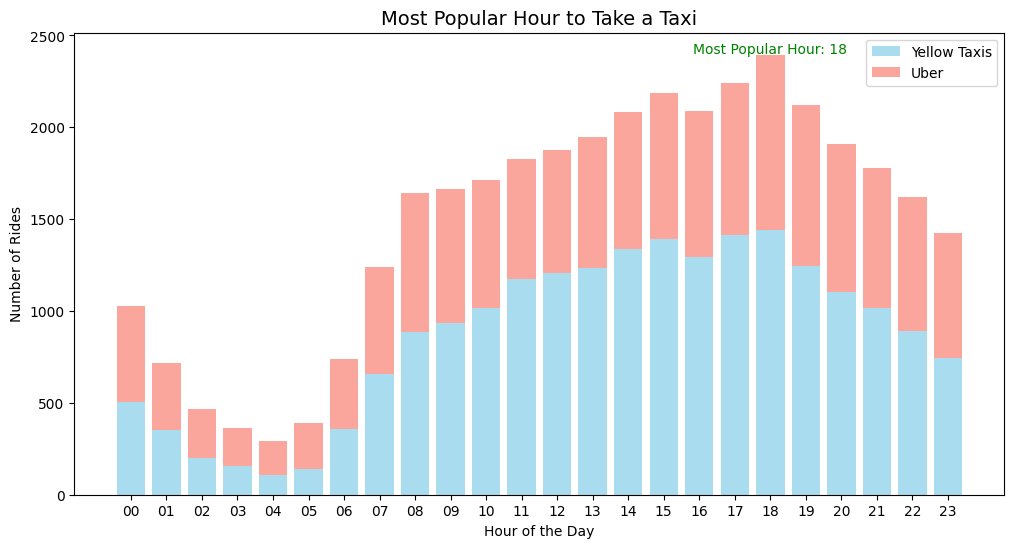

In [ ]:
some_dataframe = get_data_for_visual_1()
popularhor = plot_visual_1(some_dataframe)

**Visualization 2:** What’s the most popular month to hire a cab or Uber?

In [ ]:
"""
The function retrieves average trip distances grouped by month for both yellow taxi rides and
Uber rides between January 2020 and August 2024. It combines the results into a single dataframe,
distinguishing the ride types as `yellow_taxi` or `uber`, and returns the dataframe sorted by month.
"""
def get_data_for_visual_2():
    queryv2 = """
    WITH YellowTaxiAvgDistance AS (
        SELECT
            strftime('%m', pickup_datetime) AS month,  -- Extracting month (no year)
            trip_distance
        FROM yellow_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    ),
    UberAvgDistance AS (
        SELECT
            strftime('%m', pickup_datetime) AS month,  -- Extracting month (no year)
            trip_miles
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT
        month,
        trip_distance AS distance,
        'yellow_taxi' AS ride_type
    FROM YellowTaxiAvgDistance
    UNION ALL
    SELECT
        month,
        trip_miles AS distance,
        'uber' AS ride_type
    FROM UberAvgDistance
    ORDER BY month;
    """

    df = pd.read_sql(queryv2, conn)

    return df

In [ ]:
"""
The confidenceinterval function calculates the mean and a 90% confidence interval for a given dataset.
It uses the standard deviation, sample size, and t-value for a two-tailed distribution to compute the
margin of error and returns the mean, lower bound, and upper bound of the interval.
"""
def confidenceinterval(data, confidence=0.90):
    mean = np.mean(data)
    stddev = np.std(data)
    n = len(data)

    # Calculating the t-value for 90% confidence interval (2-tailed)
    t_value = scipy.stats.t.ppf(1 - (1 - confidence) / 2, df=n-1)

    margin_of_error = t_value * (stddev / np.sqrt(n))

    return mean, mean - margin_of_error, mean + margin_of_error

In [ ]:
"""
The `get_data_for_visual_4` function retrieves and processes monthly fare data for yellow taxis and Uber rides,
including components like fare amounts, surcharges, taxes, and tolls. It aggregates these metrics by month and
service type, pivots the data for better organization, and returns a dataframe with separate columns for each
metric by service type.
"""
def plot_visual_2(dataframe):
    # Group by month and calculate the distance
    monthly_data = dataframe.groupby(['month']).agg({'distance': 'mean'}).reset_index()
    ci_data = []
    for month in monthly_data['month'].unique():

        month_data = dataframe[dataframe['month'] == month]['distance']
        mean, lower, upper = confidenceinterval(month_data)

        ci_data.append({
            'month': month,
            'mean': mean,
            'lower': lower,
            'upper': upper})

    ci_df = pd.DataFrame(ci_data)
    final_df = pd.merge(monthly_data, ci_df, on='month', how='left') # Merging the CI data with monthly averages

    plt.figure(figsize=(12, 6))
    plt.bar(final_df['month'], final_df['mean'], yerr=[final_df['mean'] - final_df['lower'], final_df['upper'] - final_df['mean']], capsize=5, color='skyblue')
    plt.title("Average Distance Traveled Per Month (Yellow Taxis & Ubers Combined) with 90% Confidence Interval")
    plt.xlabel("Month")
    plt.ylabel("Average Distance (miles)")
    plt.show()
    return final_df

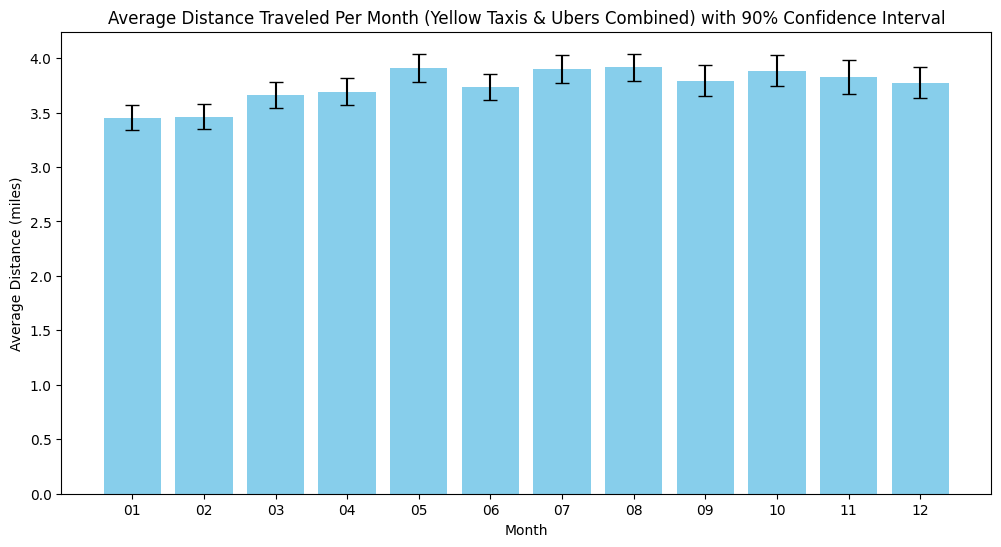

In [ ]:
some_dataframe = get_data_for_visual_2()
avgdist = plot_visual_2(some_dataframe)

**Visualization 3:** Which day of the week is most popular for taking a ride to an NYC-based airport?



In [ ]:
queryv3 = """
SELECT airport,
       CASE day_of_week
           WHEN '0' THEN 'Sunday'
           WHEN '1' THEN 'Monday'
           WHEN '2' THEN 'Tuesday'
           WHEN '3' THEN 'Wednesday'
           WHEN '4' THEN 'Thursday'
           WHEN '5' THEN 'Friday'
           WHEN '6' THEN 'Saturday'
       END AS day_of_week
FROM (
    SELECT
        CASE
            WHEN long_dropoff BETWEEN -73.890 AND -73.870
                 AND lat_dropoff BETWEEN 40.766 AND 40.780 THEN 'LGA'
            WHEN long_dropoff BETWEEN -73.790 AND -73.750
                 AND lat_dropoff BETWEEN 40.640 AND 40.660 THEN 'JFK'
            WHEN long_dropoff BETWEEN -74.200 AND -74.170
                 AND lat_dropoff BETWEEN 40.680 AND 40.700 THEN 'EWR'
            ELSE NULL
        END AS airport,
        strftime('%w', dropoff_datetime) AS day_of_week
    FROM yellow_trips
    WHERE date BETWEEN '2020-01-01' AND '2024-08-31'
    UNION ALL
    SELECT
        CASE
            WHEN long_dropoff BETWEEN -73.890 AND -73.870
                 AND lat_dropoff BETWEEN 40.766 AND 40.780 THEN 'LGA'
            WHEN long_dropoff BETWEEN -73.790 AND -73.750
                 AND lat_dropoff BETWEEN 40.640 AND 40.660 THEN 'JFK'
            WHEN long_dropoff BETWEEN -74.200 AND -74.170
                 AND lat_dropoff BETWEEN 40.680 AND 40.700 THEN 'EWR'
            ELSE NULL
        END AS airport,
        strftime('%w', dropoff_datetime) AS day_of_week
    FROM uber_trips
    WHERE date BETWEEN '2020-01-01' AND '2024-08-31'
) WHERE airport IS NOT NULL;
"""

data = pd.read_sql(queryv3, conn)

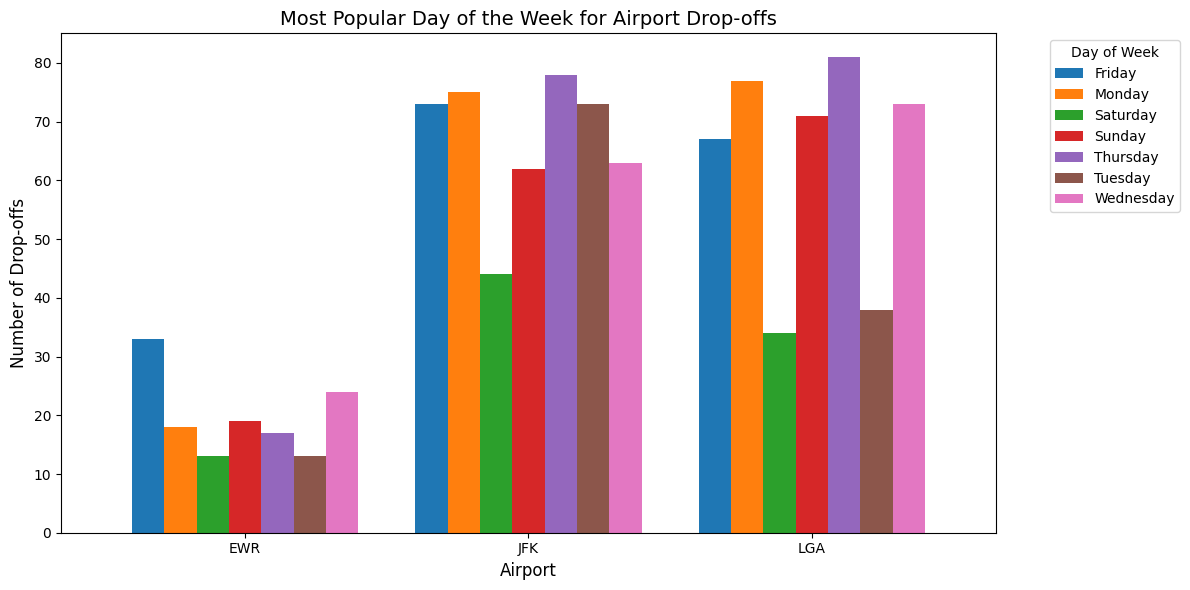

In [ ]:
grouped = data.groupby(["airport", "day_of_week"]).size().unstack()
grouped.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Most Popular Day of the Week for Airport Drop-offs", fontsize=14)
plt.xlabel("Airport", fontsize=12)
plt.ylabel("Number of Drop-offs", fontsize=12)
plt.legend(title="Day of Week", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Visualization 4:** How much do hired rides earn in total fares monthly?


In [ ]:
"""
The `get_data_for_visual_4` function retrieves and processes monthly fare data for yellow taxis and Uber rides,
including components like fare amounts, surcharges, taxes, and tolls. It aggregates these metrics by month and
service type, pivots the data for better organization, and returns a dataframe with separate columns for each
metric by service type.
"""
def get_data_for_visual_4() -> pd.DataFrame:
    queryv4 = """
    SELECT
        strftime('%Y-%m', date) AS month,
        'Yellow Taxi' AS service_type,
        SUM(fare_amount) AS fare_amount,
        SUM(surcharges) AS surcharges,
        SUM(taxes) AS taxes,
        SUM(tolls) AS tolls,
        SUM(fare_amount + surcharges + taxes + tolls) AS total_fare
    FROM yellow_trips
    WHERE date BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month
    UNION ALL
    SELECT
        strftime('%Y-%m', date) AS month,
        'Uber' AS service_type,
        SUM(fare_amount) AS fare_amount,
        SUM(surcharges) AS surcharges,
        SUM(taxes) AS taxes,
        SUM(tolls) AS tolls,
        SUM(fare_amount + surcharges + taxes + tolls) AS total_fare
    FROM uber_trips
    WHERE date BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month, service_type
    ORDER BY month;
    """

    df = pd.read_sql(queryv4, conn)

    df['month'] = pd.to_datetime(df['month'])
    df_pivot = df.pivot_table(index='month', columns='service_type', values=['fare_amount', 'surcharges', 'taxes', 'tolls'], aggfunc='sum')
    df_pivot.columns = [f'{col[0]}_{col[1]}' for col in df_pivot.columns]
    return df_pivot

<Figure size 1400x800 with 0 Axes>

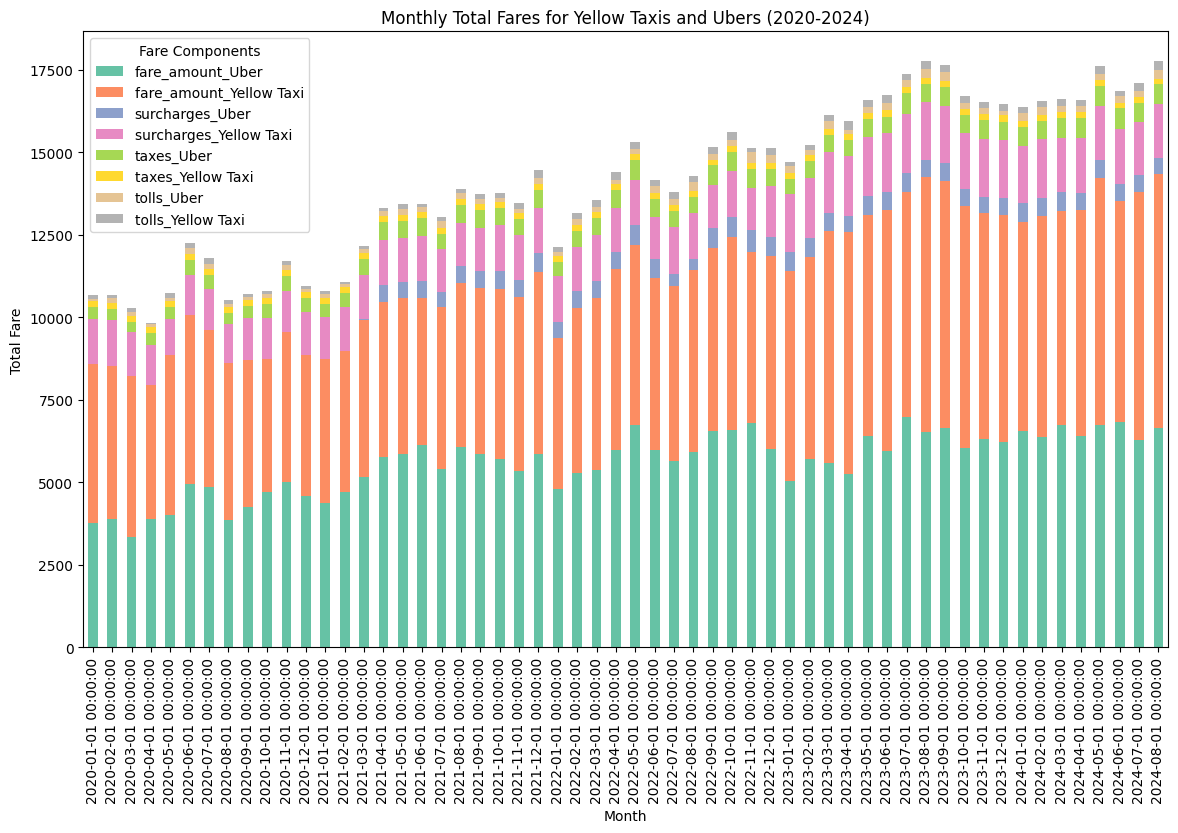

In [ ]:
"""
The `plot_visual_4` function generates a stacked bar chart to display the monthly total fares for yellow taxis and
Uber rides from 2020 to 2024. It uses fare components such as fare amounts, surcharges, taxes, and tolls as the
stacked elements, with a legend indicating the fare components and axes labeled for clarity.
"""
def plot_visual_4(dataframe: pd.DataFrame) -> None:
    plt.figure(figsize=(14, 8))
    axes = dataframe.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')
    plt.title('Monthly Total Fares for Yellow Taxis and Ubers (2020-2024)')
    plt.xlabel('Month')
    plt.ylabel('Total Fare')
    plt.legend(title='Fare Components', loc='upper left')
    plt.show()

df_fares = get_data_for_visual_4()
plot_visual_4(df_fares)

**Visualization 5:** Does precipitation or distance traveled affect the amount of tip?


In [ ]:
"""
The function retrieves data to analyze how precipitation and trip distance affect the amount of tips for yellow taxis
and Uber rides. It joins ride data with weather data, aggregates by date, includes trip distance and precipitation as
features, filters for a specific date range (2022–2023), and returns a cleaned dataframe after dropping rows with
missing values.
"""
def get_data_for_visual_5() -> pd.DataFrame:
    queryv5 = """
    SELECT
        trips.date,
        trips.tips,
        trips.trip_distance,
        weather.precipitation,
        'Yellow Taxi' AS service_type
    FROM yellow_trips AS trips
    JOIN hourly_weather AS weather ON trips.date = weather.date
    WHERE trips.date BETWEEN '2022-01-01' AND '2023-12-31'

    UNION ALL

    SELECT
        trips.date,
        trips.tips,
        trips.trip_miles AS trip_distance,
        weather.precipitation,
        'Uber' AS service_type
    FROM uber_trips AS trips
    JOIN hourly_weather AS weather ON trips.date = weather.date
    WHERE trips.date BETWEEN '2022-01-01' AND '2023-12-31';
    """

    df = pd.read_sql(queryv5, conn)
    df = df.dropna()
    return df

In [ ]:
"""
The function creates a 2x2 scatter plot grid to visualize the relationship between tips and two
variables—distance traveled and precipitation—for both yellow taxis and Uber rides. Each subplot focuses
on a specific combination of service type and variable, with appropriate titles, labels, and legends to
highlight trends in the data.
"""
def plot_visual_5(dataframe: pd.DataFrame) -> None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Tip vs distance for taxis
    axes[0, 0].scatter(dataframe[dataframe['service_type'] == 'Yellow Taxi']['trip_distance'],
                       dataframe[dataframe['service_type'] == 'Yellow Taxi']['tips'],
                       color='blue', label='Yellow Taxi')
    axes[0, 0].set_title('Tip vs Distance (Yellow Taxi)')
    axes[0, 0].set_xlabel('Distance Traveled (miles)')
    axes[0, 0].set_ylabel('Tip Amount (USD)')
    axes[0, 0].legend()

    # Tip vs distance for Uber
    axes[0, 1].scatter(dataframe[dataframe['service_type'] == 'Uber']['trip_distance'],
                       dataframe[dataframe['service_type'] == 'Uber']['tips'],
                       color='green', label='Uber')
    axes[0, 1].set_title('Tip vs Distance (Uber)')
    axes[0, 1].set_xlabel('Distance Traveled (miles)')
    axes[0, 1].set_ylabel('Tip Amount (USD)')
    axes[0, 1].legend()

    # Tip vs precipitation for taxis
    axes[1, 0].scatter(dataframe[dataframe['service_type'] == 'Yellow Taxi']['precipitation'],
                       dataframe[dataframe['service_type'] == 'Yellow Taxi']['tips'],
                       color='blue', label='Yellow Taxi')
    axes[1, 0].set_title('Tip vs Precipitation (Yellow Taxi)')
    axes[1, 0].set_xlabel('Precipitation (inches)')
    axes[1, 0].set_ylabel('Tip Amount (USD)')
    axes[1, 0].legend()

    # Tip vs precipitation for Uber
    axes[1, 1].scatter(dataframe[dataframe['service_type'] == 'Uber']['precipitation'],
                       dataframe[dataframe['service_type'] == 'Uber']['tips'],
                       color='green', label='Uber')
    axes[1, 1].set_title('Tip vs Precipitation (Uber)')
    axes[1, 1].set_xlabel('Precipitation (inches)')
    axes[1, 1].set_ylabel('Tip Amount (USD)')
    axes[1, 1].legend()

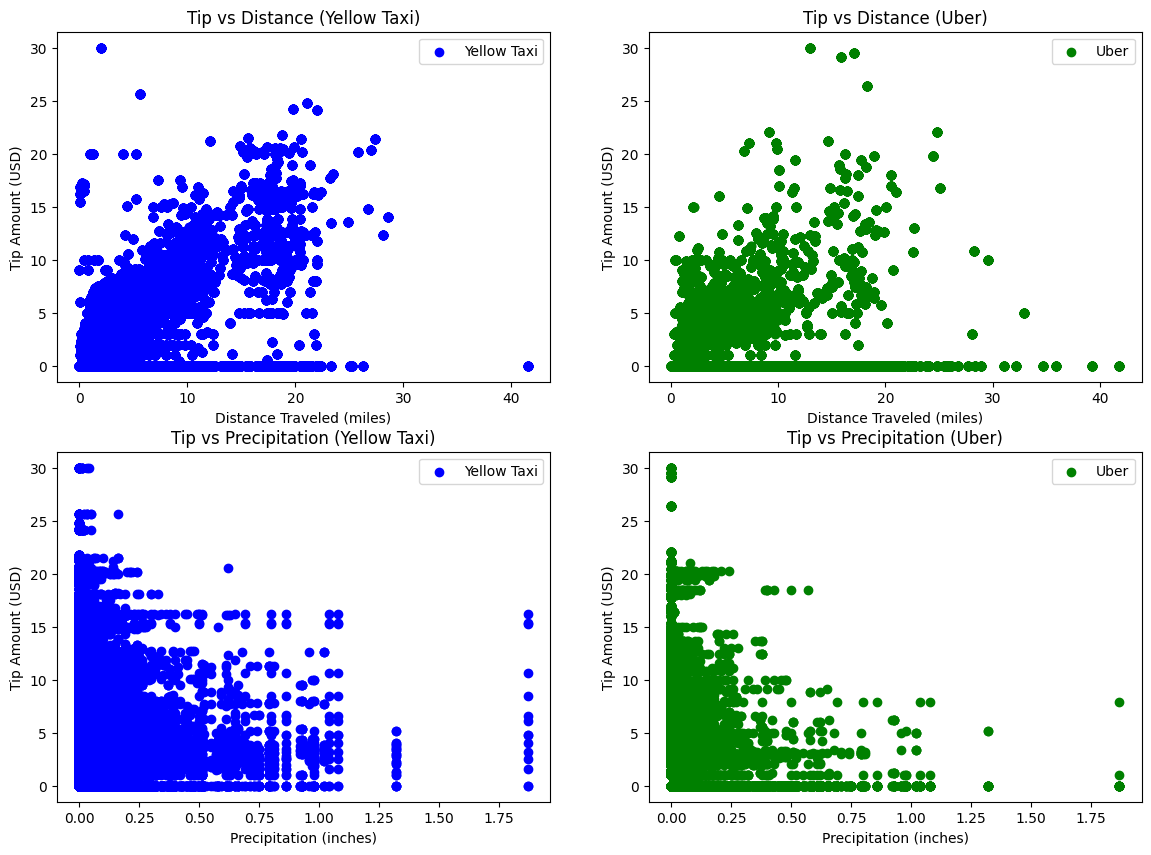

In [ ]:
plt.show()
df = get_data_for_visual_5()
plot_visual_5(df)

**Visualization 6:** Create a heatmap

In [ ]:
import folium
from folium.plugins import HeatMap

def get_data_for_visual_6() -> pd.DataFrame:
    queryv6 = """
    SELECT lat_dropoff, long_dropoff, date
    FROM (
        SELECT lat_dropoff, long_dropoff, date FROM yellow_trips
        UNION ALL
        SELECT lat_dropoff, long_dropoff, date FROM uber_trips
    ) AS combined_trips
    WHERE date BETWEEN '2020-01-01' AND '2020-12-31';
    """

    df = pd.read_sql(queryv6, conn)
    return df


In [ ]:
"""
The function generates an interactive heatmap of drop-off locations in New York City using Folium.
It takes a dataframe with latitude and longitude coordinates, creates a heatmap overlay based on the density
of drop-off points, and centers the map on NYC coordinates with a zoom level of 12. The function returns the
Folium map object.
"""
def plot_visual_6(dataframe: pd.DataFrame) -> None:
    m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)  # New York City coordinates
    heat_data = [[row['lat_dropoff'], row['long_dropoff']] for index, row in dataframe.iterrows()]
    HeatMap(heat_data).add_to(m)
    return m

df = get_data_for_visual_6()
heatmap = plot_visual_6(df)
heatmap
